<a href="https://www.kaggle.com/code/pranauvskandhan/dynamical-mass-estimation-of-a-galaxy-cluster-sds?scriptVersionId=256322078" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

In [2]:
import pandas as pd

df = pd.read_csv(
    "/kaggle/input/dynamical-mass-estimation/Skyserver_SQL8_14_2025 8_53_32 AM.csv",
    header=0,
    comment="#"
)

df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type
0,1237671768542544161,257.93432,64.112149,0.060484,0.014358,0.083330,0.000013,5.245600,18.43272,0.039535,17.00699,0.005048,16.40314,0.004619,3
1,1237671768542544203,257.95663,64.168201,0.077933,0.016806,0.077282,0.000026,6.405518,20.34147,0.118916,18.23995,0.008797,17.37372,0.006650,3
2,1237671768542544274,258.05701,64.141009,0.065652,0.010237,0.073619,0.000027,3.468454,19.24696,0.062592,17.34149,0.005956,16.46408,0.004595,3
3,1237671768542544274,258.05701,64.141009,0.065652,0.010237,0.073673,0.000022,3.468454,19.24696,0.062592,17.34149,0.005956,16.46408,0.004595,3
4,1237671939804561434,258.02787,64.040384,0.155318,0.008394,0.150862,0.000026,4.113855,19.82627,0.076834,17.78582,0.006977,16.65903,0.004430,3


In [3]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

In [4]:
averaged_df['specz'].mean(),3*averaged_df['specz'].std(), averaged_df['specz'].mean()+3*averaged_df['specz'].std()

(0.08083762565217391, 0.0257328417489049, 0.10657046740107881)

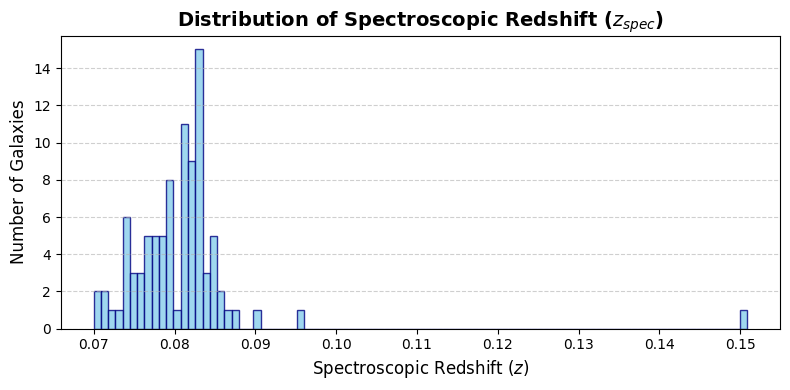

In [5]:
# Distribution of Spectroscopic Redshift 

# histogram
plt.figure(figsize=(8, 4))
plt.hist(
    averaged_df['specz'], 
    bins=90, 
    color='skyblue',       
    edgecolor='navy',      
    alpha=0.8
)

plt.title("Distribution of Spectroscopic Redshift ($z_{spec}$)", fontsize=14, fontweight='bold')
plt.xlabel("Spectroscopic Redshift ($z$)", fontsize=12)
plt.ylabel("Number of Galaxies", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

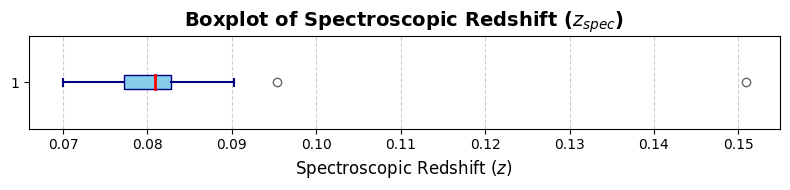

In [6]:
# Boxplot of Spectroscopic Redshift

# boxplot
plt.figure(figsize=(8, 2))
plt.boxplot(
    averaged_df['specz'], 
    vert=False, 
    patch_artist=True,       
    boxprops=dict(facecolor='skyblue', color='navy'),
    whiskerprops=dict(color='navy', linewidth=1.5),
    capprops=dict(color='navy', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='orange', alpha=0.6)
)

plt.title("Boxplot of Spectroscopic Redshift ($z_{spec}$)", fontsize=14, fontweight='bold')
plt.xlabel("Spectroscopic Redshift ($z$)", fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 3σ Filtering of Spectroscopic Redshift

To remove potential outliers from the galaxy sample, we applied a **three-sigma (3σ) filter** to the spectroscopic redshift (`specz`) distribution:

1. **Compute Central Tendency and Spread**  
   The **mean redshift** $(\bar{z})$ and **standard deviation** $(\sigma)$ of the sample were calculated.

2. **Define Filtering Bounds**  
   The **retention limits** were set as:
   $$
   z_{\text{min}} = \bar{z} - 3\sigma,\quad z_{\text{max}} = \bar{z} + 3\sigma
   $$

3. **Select Inliers**  
   Only galaxies with $z_{\text{min}} \leq z \leq z_{\text{max}}$ were retained.

4. **Rationale**  
   This statistical filtering step excludes extreme outliers in redshift, improving data quality and ensuring that the retained galaxies are representative of the main cluster population.

In [7]:
#3σ Filtering of Redshift
z_mean = averaged_df['specz'].mean()      # mean spectroscopic redshift
z_std  = averaged_df['specz'].std()       # standard deviation of redshift

#3-sigma limits
z_min = z_mean - 3 * z_std
z_max = z_mean + 3 * z_std

# filter galaxies within ±3σ
filtered_df = averaged_df[(averaged_df['specz'] >= z_min) & (averaged_df['specz'] <= z_max)]

print(f"Mean redshift: {z_mean:.5f}")
print(f"Standard deviation: {z_std:.5f}")
print(f"3σ limits: {z_min:.5f} – {z_max:.5f}")
print(f"Number of galaxies after 3σ filtering: {len(filtered_df)}")

Mean redshift: 0.08084
Standard deviation: 0.00858
3σ limits: 0.05510 – 0.10657
Number of galaxies after 3σ filtering: 91


### Calculating the Redshift of the Filtered Galaxy Cluster

After applying the 3σ filter to remove outliers, we calculate the **mean spectroscopic redshift** of the remaining cluster members:

In [8]:
# calculating redhsift of filtered cluster
cluster_redshift = filtered_df['specz'].mean()
print(f"The value of the cluster redshift = {cluster_redshift:.4f}")

The value of the cluster redshift = 0.0801


### Velocity Dispersion of Filtered Cluster Galaxies

To characterize the kinematic properties of the filtered cluster members:

- The **speed of light** is converted to km/s using `astropy.constants`.
- **Radial velocities** for each galaxy are calculated as:
  $$
  v = c \times z_{\text{spec}}
  $$
  where $c$ is the speed of light and $z_{\text{spec}}$ is the spectroscopic redshift.

- The **velocity dispersion** $(\sigma_v)$, a measure of the spread in galaxy velocities, is computed as the standard deviation of these velocities.

- A **histogram** of the radial velocity distribution is plotted to visualize the velocity structure of the cluster.

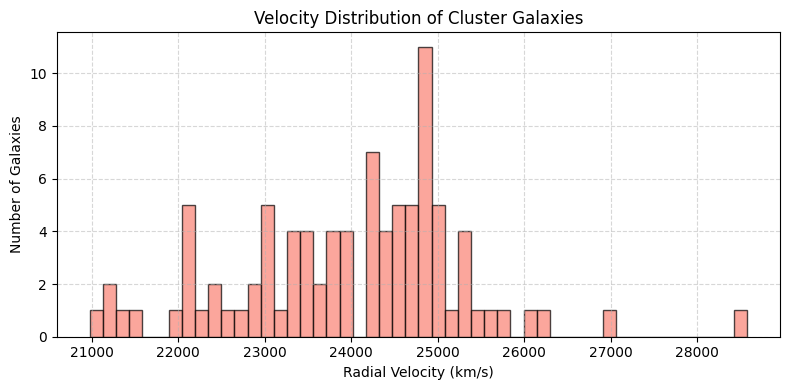

Velocity Dispersion (σ_v) = 1316.15 km/s


In [9]:
from astropy.constants import c
c_kms = c.to('km/s').value  # speed of light in km/s

filtered_df = filtered_df.copy()
filtered_df.loc[:, 'velocity'] = c_kms * filtered_df['specz']

# compute velocity dispersion
velocity_dispersion = filtered_df['velocity'].std()

# histogram of radial velocities
plt.figure(figsize=(8, 4))
plt.hist(filtered_df['velocity'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.title("Velocity Distribution of Cluster Galaxies")
plt.xlabel("Radial Velocity (km/s)")
plt.ylabel("Number of Galaxies")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Velocity Dispersion (σ_v) = {velocity_dispersion:.2f} km/s")

### Estimating the Projected Radius of the Galaxy Cluster

To calculate the **projected cluster radius**, we perform the following steps:

- **Convert Projected Separation:**  
  The projected separation of each galaxy from the cluster center is converted from arcminutes to radians.
- **Compute Mean Redshift and Angular Diameter Distance:**  
  The mean cluster redshift is calculated, and the corresponding **angular diameter distance** ($D_A$) is computed using the adopted cosmological model.
- **Calculate Projected Physical Distances:**  
  Each galaxy’s projected separation is converted to physical units (parsecs) using:
  $$
  \text{projected distance} = D_A \times \theta
  $$
  where $\theta$ is the projected separation in radians.
- **Estimate Cluster Radius:**  
  The cluster’s projected radius is estimated as the mean of these projected distances.

In [10]:
# projected separation from arcmin to radians
filtered_df = filtered_df.copy()  
filtered_df.loc[:, 'proj_sep_rad'] = (filtered_df['proj_sep'].values * u.arcmin).to(u.radian).value

# mean redshift & angular diameter distance 
z_mean = filtered_df['specz'].mean()
D_A = cosmo.angular_diameter_distance(z_mean).to(u.pc).value  # in parsecs

# projected distances in parsecs
filtered_df.loc[:, 'projected_distance_pc'] = D_A * filtered_df['proj_sep_rad']

# estimating cluster radius as mean projected distance
cluster_radius_pc = filtered_df['projected_distance_pc'].mean()

print(f"Estimated Cluster Radius: {cluster_radius_pc:.2f} pc")

Estimated Cluster Radius: 569868.35 pc


In [11]:
# speed of light in km/s
c_kms = c.to('km/s').value

# relative velocity w.r.t. cluster redshift
# v = c * (z - z_cluster) / (1 + z_cluster)
filtered_df = filtered_df.copy() 
filtered_df.loc[:, 'v_rel'] = c_kms * (filtered_df['specz'] - cluster_redshift) / (1 + cluster_redshift)

# velocity dispersion
dispersion = filtered_df['v_rel'].std()
print(f"Characteristic velocity dispersion along the line of sight: {dispersion:.2f} km/s")

# Summary statistics
print(filtered_df['v_rel'].describe())

Characteristic velocity dispersion along the line of sight: 1218.58 km/s
count    9.100000e+01
mean    -6.484522e-12
std      1.218583e+03
min     -2.801145e+03
25%     -8.055229e+02
50%      2.372730e+02
75%      7.559306e+02
max      4.236062e+03
Name: v_rel, dtype: float64


### Visualizing Projected Angular Separation of Cluster Galaxies

A histogram is plotted to show the distribution of projected angular separations for galaxies within the cluster:

- **X-axis:** Angular separation from the cluster center (arcminutes).
- **Y-axis:** Number of galaxies.
- The visualization helps to assess the spatial concentration and extent of galaxies in the cluster.

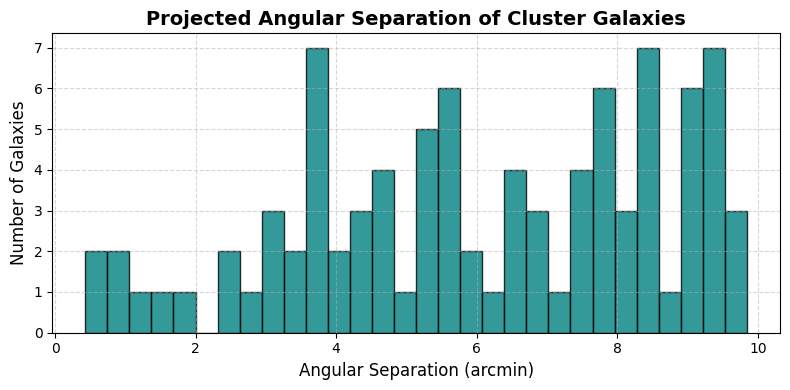

In [12]:
# visualizing Projected Angular Separation of Galaxies 
plt.figure(figsize=(8, 4))

plt.hist(
    filtered_df['proj_sep'], 
    bins=30, 
    color='teal',           
    edgecolor='black', 
    alpha=0.8
)

plt.title("Projected Angular Separation of Cluster Galaxies", fontsize=14, fontweight='bold')
plt.xlabel("Angular Separation (arcmin)", fontsize=12)
plt.ylabel("Number of Galaxies", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Calculating Co-moving Distance to the Cluster

The **co-moving distance** ($r$) to the galaxy cluster is estimated using the following formula, which accounts for manual cosmological constants and the cluster’s redshift:

$$
r = \left(\frac{c \, z}{H_0}\right) \left[1 + \frac{1 - q_0}{2} \, z\right]
$$

where:
- $c$ is the speed of light (km/s),
- $z$ is the cluster redshift,
- $H_0$ is the Hubble constant (km/s/Mpc),
- $q_0$ is the deceleration parameter.



In [13]:
# Manual constants
q0 = -0.534
H0 = 70
z = cluster_redshift
c_kms = c.to('km/s').value
r = (c_kms * z / H0) * (1 + ((1 - q0) / 2) * z)
print(f"Co-moving distance r = {r:.2f} Mpc")

Co-moving distance r = 363.97 Mpc


In [14]:
 # Angular diameter distance
ra = r / (1 + z)
print(f"Angular diameter distance r = {ra:.2f} Mpc")

Angular diameter distance r = 336.99 Mpc


### Estimating the Physical Diameter of the Cluster

The **physical diameter** of the galaxy cluster is calculated from the maximum projected angular separation and the angular diameter distance:

- $\theta_{\text{max}}$: Maximum projected angular separation (arcminutes)
- $\theta_{\text{max, rad}}$: Converted to radians
- $r_a$: Angular diameter distance (Mpc)

The calculation is:

$$
D = \theta_{\text{max, rad}} \times r_a
$$

where
- $\theta_{\text{max, rad}} = \frac{\theta_{\text{max}}}{60}$ (to degrees) and then convert to radians using $\text{np.deg2rad}$.

In [15]:
theta_arcmin = filtered_df['proj_sep'].max()
theta_rad = np.deg2rad(theta_arcmin / 60)
diameter = theta_rad * ra
print(f"Estimated Physical Diameter = {diameter:.2f} Mpc")

Estimated Physical Diameter = 0.97 Mpc


### Angular Spread of Cluster Galaxies

A **scatter plot** is used to visualize the sky positions of galaxies in the cluster:

- **X-axis:** Right Ascension (degrees)
- **Y-axis:** Declination (degrees)
- Each point represents an individual galaxy’s coordinates.
- The plot includes professional color styling, black edges for clarity, and moderate transparency for better readability.

The right ascension axis is inverted to match astronomical convention (RA increases to the left).



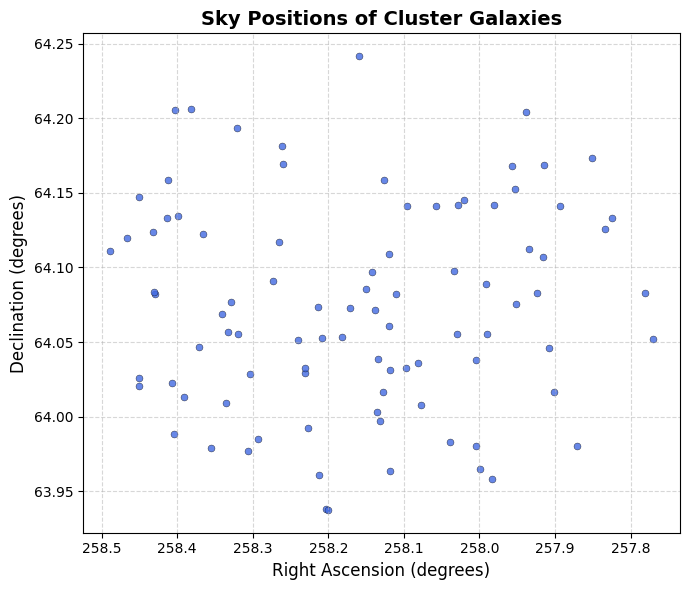

In [16]:
# angular Spread of Cluster Galaxies
plt.figure(figsize=(7, 6))

plt.scatter(
    filtered_df['ra'], 
    filtered_df['dec'], 
    color='royalblue',  
    s=25,              
    alpha=0.8,          
    edgecolor='k',      
    linewidth=0.3
)

plt.title("Sky Positions of Cluster Galaxies", fontsize=14, fontweight='bold')
plt.xlabel("Right Ascension (degrees)", fontsize=12)
plt.ylabel("Declination (degrees)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis() 
plt.tight_layout()
plt.show()

In [17]:
from astropy.constants import G, M_sun
import astropy.units as u

velocity_dispersion_kms = 1316.15  # km/s 
cluster_radius_pc = 569868.35     # parsec

# radius to meters
R_m = (cluster_radius_pc * u.pc).to(u.m).value

# velocity to m/s 
v = velocity_dispersion_kms * 1e3  # km/s -> m/s

# Dynamical mass calculation
G_si = G.value  
M_kg = 3 * v**2 * R_m / G_si       
M_dyn = M_kg / M_sun.value         # convert to solar masses

print(f"Velocity Dispersion (σ) = {velocity_dispersion_kms:.2f} km/s")
print(f"Cluster Radius = {cluster_radius_pc:.2f} pc")
print(f"Dynamical Mass of the Cluster = {M_dyn:.2e} M_sun")

Velocity Dispersion (σ) = 1316.15 km/s
Cluster Radius = 569868.35 pc
Dynamical Mass of the Cluster = 6.89e+14 M_sun


**Dynamical Mass of a Galaxy Cluster**

The **dynamical mass** of a galaxy cluster is a time-dependent quantity, evolving as the cluster grows via mergers, accretion of galaxies, and dark matter infall. Although this value changes over cosmic time, the dynamical mass can be estimated at any given epoch by analyzing the motions of member galaxies or the dynamics of the intracluster medium. These measurements provide critical insight into the cluster’s gravitational potential and total matter content.